In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
import rasterio
from rasterio.mask import mask
import geopandas as gpd
from datetime import datetime

/var/folders/z3/3cfhh53113v2gvks_21cwb080000gn/T/ipykernel_2947/2371991652.py:18: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  aoi_geometry = [aoi.unary_union]


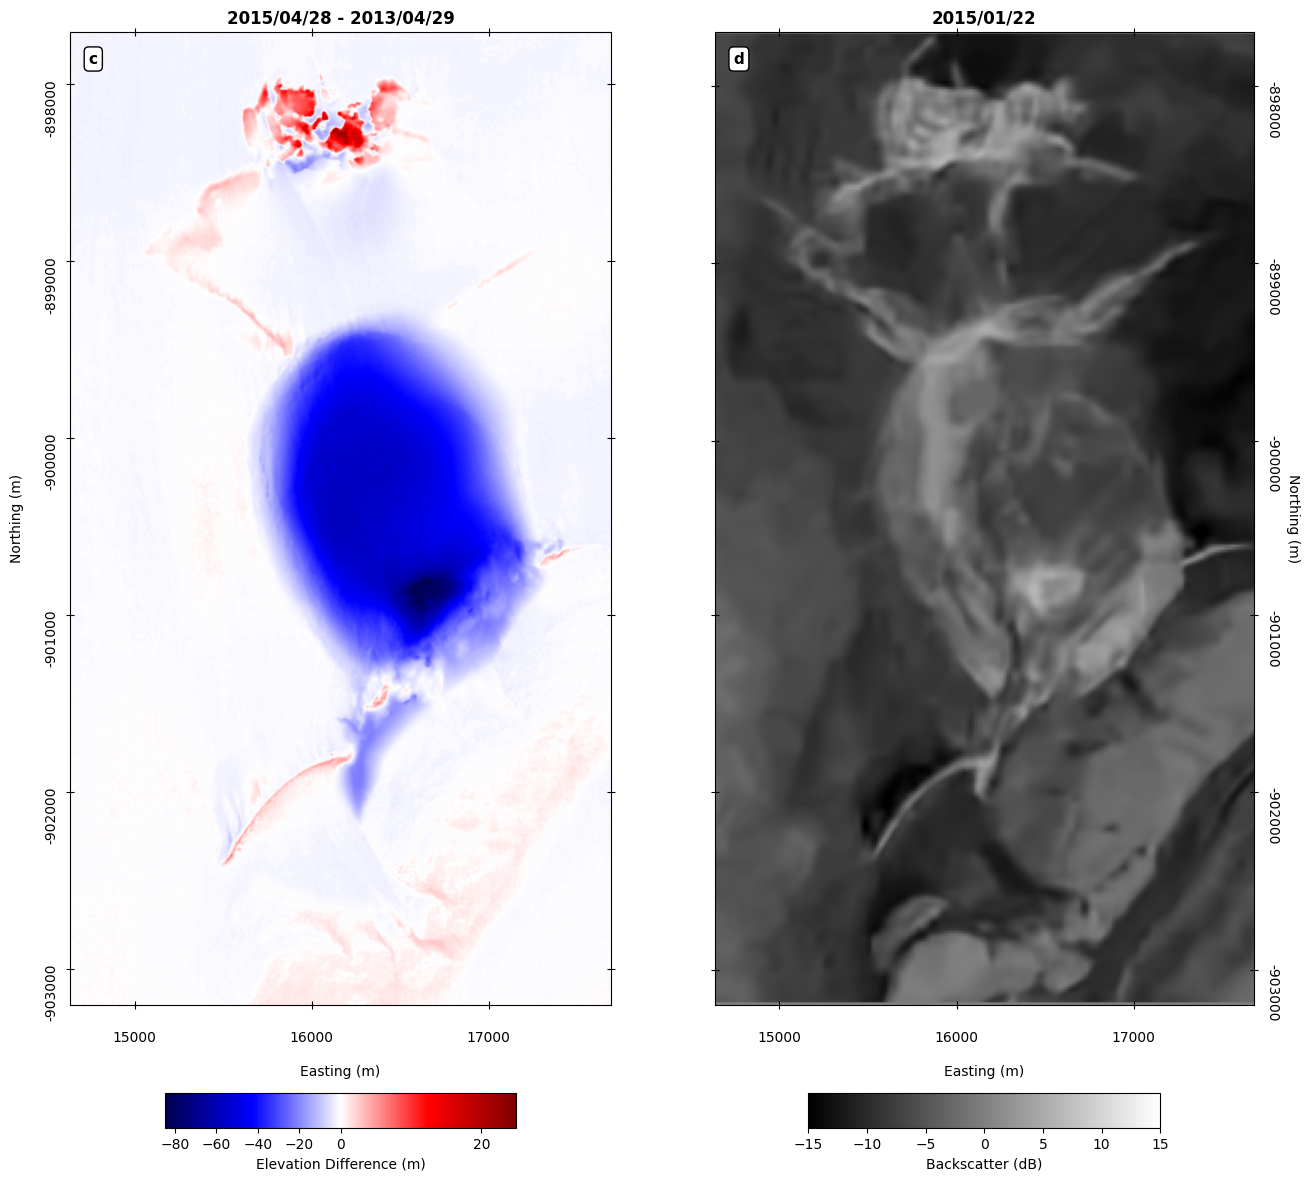

In [15]:
# Directories and files
main_dir = './Harder_Glacier_subglacial_outburst/'
corrected_dem_folder = main_dir + "/ArcticDEM_Stripfiles/Corrected_ArcticDEM_Stripfiles/"
aoi_shapefile = main_dir + '/AOI/AOI_DEM_Difference.shp'
s1_folder = main_dir + "/Sentinel-1/"

file2 = 'SETSM_s2s041_WV02_20130429_103001002251CD00_10300100227A1B00_2m_lsf_seg1_dem.tif'
file1 = 'SETSM_s2s041_WV03_20150428_104001000A25AB00_104001000A131500_2m_lsf_seg1_dem.tif'
s1 = 'amp-S1A20150122_F1_15m_BM3D_db.tif'

# Dates for title
file1_date = datetime.strptime(file1.split('_')[3], "%Y%m%d").strftime("%Y/%m/%d")
file2_date = datetime.strptime(file2.split('_')[3], "%Y%m%d").strftime("%Y/%m/%d")
s1_date = datetime.strptime(s1.split('-')[1][3:11], "%Y%m%d").strftime("%Y/%m/%d")

# Load AOI
aoi = gpd.read_file(aoi_shapefile).to_crs("EPSG:3413")
aoi_geometry = [aoi.unary_union]

# Clip and fill function
def clip_and_fill_dem(dem_path, geometry, nodata_value=-9999):
    with rasterio.open(dem_path) as src:
        out_image, out_transform = mask(src, geometry, crop=True)
        out_meta = src.meta.copy()
        out_meta.update({
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform
        })
        out_image = np.where(out_image == nodata_value, np.nan, out_image)
        return out_image[0], out_meta, out_transform

# Load DEMs and S1
dem1_clipped, dem1_meta, dem1_transform = clip_and_fill_dem(corrected_dem_folder + file1, aoi_geometry)
dem2_clipped, _, _ = clip_and_fill_dem(corrected_dem_folder + file2, aoi_geometry)
s1_clipped, s1_meta, s1_transform = clip_and_fill_dem(s1_folder + s1, aoi_geometry)

# Ensure same shape
max_h = max(dem1_clipped.shape[0], dem2_clipped.shape[0])
max_w = max(dem1_clipped.shape[1], dem2_clipped.shape[1])
pad = lambda x: np.pad(x, ((0, max_h - x.shape[0]), (0, max_w - x.shape[1])), constant_values=np.nan)
dem1_clipped, dem2_clipped = pad(dem1_clipped), pad(dem2_clipped)

# Compute difference
difference = dem1_clipped - dem2_clipped

# Function to set ticks on all four sides and customize tick labels.
def set_ticks(ax, transform, array, right_labels=False):
    height, width = array.shape

    # Get bounds in map units
    left, top = rasterio.transform.xy(transform, 0, 0)
    right, bottom = rasterio.transform.xy(transform, height - 1, width - 1)

    # Determine neat intervals for ticks (1000m spacing)
    x_ticks_coords = np.arange(np.floor(left / 1000) * 1000, np.ceil(right / 1000) * 1000 + 1, 1000)
    y_ticks_coords = np.arange(np.floor(bottom / 1000) * 1000, np.ceil(top / 1000) * 1000 + 1, 1000)

    # Convert map coordinates to pixel indices for tick placement
    inv_transform = ~transform
    x_tick_pixels = [int(round((inv_transform * (x, top))[0])) for x in x_ticks_coords]
    y_tick_pixels = [int(round((inv_transform * (left, y))[1])) for y in y_ticks_coords]

    # Clip ticks to valid pixel range
    x_tick_pairs = [(x, lbl) for x, lbl in zip(x_tick_pixels, x_ticks_coords) if 0 <= x < width]
    y_tick_pairs = [(y, lbl) for y, lbl in zip(y_tick_pixels, y_ticks_coords) if 0 <= y < height]

    # Unzip to separate lists
    if x_tick_pairs:
        x_ticks, x_labels = zip(*x_tick_pairs)
        ax.set_xticks(x_ticks)
        ax.set_xticklabels([str(int(x)) for x in x_labels])
    if y_tick_pairs:
        y_ticks, y_labels = zip(*y_tick_pairs)
        ax.set_yticks(y_ticks)
        if not right_labels:
            ax.set_yticklabels([str(int(y)) for y in y_labels], rotation=90, ha='left')
            ax.yaxis.set_label_position("left")
            ax.yaxis.tick_left()
        else:
            ax.set_yticklabels([str(int(y)) for y in y_labels], rotation=270, ha='right')
            ax.yaxis.set_label_position("right")
            ax.yaxis.tick_right()

    ax.tick_params(
        top=True, bottom=True, left=True, right=True,
        direction='inout',
        length=6,
        pad=15
    )

# Set up plots
fig, axes = plt.subplots(1, 2, figsize=(14, 13))

# Plot 1: DEM difference
norm1 = TwoSlopeNorm(vmin=np.nanmin(difference), vcenter=0, vmax=np.nanmax(difference))
im1 = axes[0].imshow(difference, cmap='seismic', norm=norm1)
axes[0].set_title(f"{file1_date} - {file2_date}", fontweight='bold')
axes[0].set_xlabel("Easting (m)", labelpad=15)  # Increased labelpad for padding
axes[0].set_ylabel("Northing (m)", labelpad=15)  # Increased labelpad for padding

# Plot 2: Sentinel-1 backscatter
norm2 = TwoSlopeNorm(vmin=np.nanmin(s1_clipped), vcenter=0, vmax=np.nanmax(s1_clipped))
im2 = axes[1].imshow(s1_clipped, cmap='gray', norm=norm2)
axes[1].set_title(f"{s1_date}", fontweight='bold')
axes[1].set_xlabel("Easting (m)", labelpad=15)  # Increased labelpad for padding
axes[1].set_ylabel("Northing (m)", labelpad=15, rotation=270)  # Increased labelpad for padding
axes[1].yaxis.set_label_position("right")  # Explicitly set label on right side

# Apply the ticks to both plots
set_ticks(axes[0], dem1_transform, difference, right_labels=False)  # For plot 1, labels on left and bottom
set_ticks(axes[1], s1_transform, s1_clipped, right_labels=True)  # For plot 2, labels on right and bottom

# Colorbars
cbar1 = fig.colorbar(im1, ax=axes[0], orientation='horizontal', pad=0.07, shrink=0.5, aspect=10)
cbar1.set_label("Elevation Difference (m)")
im1.set_clim(-85, 25)

cbar2 = fig.colorbar(im2, ax=axes[1], orientation='horizontal', pad=0.07, shrink=0.5, aspect=10)
cbar2.set_label("Backscatter (dB)")
im2.set_clim(-15, 15)

axes[0].text(
    0.035, 0.98, "c",  # Normalized coordinates within the plot
    fontsize=11, fontweight='bold', color='black', ha='left', va='top',
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'),
    transform=axes[0].transAxes
)

axes[1].text(
    0.035, 0.98, "d",  # Normalized coordinates within the plot
    fontsize=11, fontweight='bold', color='black', ha='left', va='top',
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'),
    transform=axes[1].transAxes
)

# Adjust spacing and layout
plt.subplots_adjust(wspace=0.1, hspace=0.1)  # Decrease wspace to bring plots closer together

# Prevent overflow and adjust layout
plt.tight_layout()
plt.show()
